# Advanced preprocessing

# Table of Contents
- Load data
- Merge duplicated rows in `fcst` using mean / most recent fcst
- Convert the measure of `Cloud` in `fcst` to `obs`
- Interpolate fcst
- Convert dtype of 'time' in `energy`
- Merge fcst, obs, and energy
- Fill missing values in using ffill
- Add seasonality (day and year)

## Load data
- from basic_processing.ipynb

In [1]:
import pickle
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('pickles/basic/dangjin_fcst_data.pkl','rb') as f:
    dangjin_fcst = pickle.load(f)
with open('pickles/basic/dangjin_obs_data.pkl','rb') as f:
    dangjin_obs = pickle.load(f)
with open('pickles/basic/ulsan_fcst_data.pkl','rb') as f:
    ulsan_fcst = pickle.load(f)
with open('pickles/basic/ulsan_obs_data.pkl', 'rb') as f:
    ulsan_obs = pickle.load(f)

energy = pd.read_csv(glob('../original_dataset/energy.csv')[0])

## Merge duplicated rows in `fcst` using the most recent forecast

In [3]:
def merge_to_recent(data, time, due_hour = 21):
    '''
    @warning
    data에 'Forecast time'(기상 예측이 이루어진 시점) column이 존재해야 함.

    @description
    fcst에서 'time'이 중복되는 row들을 하나로 통합한다.
    이때, 가장 최근의 fcst data로 통합한다. (즉, 가장 최근의 fcst data 이외의 row는 모두 삭제한다.)
    '가장 최근'이라는 것은, 해당 'time'의 전날의 due_hour까지다. 
    예를 들어 2021-05-02 14:00:00(=time)를 예측하고, due_hour = 21이라면,
    2021-05-01 21:00:00 전까지의 row 중 가장 최근의 fcst로 통합한다.

    @parameters
    data: pd.DataFrame ; 통합이 이루어질 dataframe
    time: pd.Timestamp ; 통합하려는 time
    due_hour: int ; description 참고

    @return
    pd.Series ; 통합된 하나의 row

    '''
    # data only with the given time
    data_only_with_time = data.loc[data['time'] == time]
    
    # shift time
    time = time - pd.Timedelta(1, unit='days') # shifting 1 day to the past (yesterday)
    time = time.replace(hour=due_hour) # change 'hour' to DUE_HOUR

    # most recent forecast
    return data_only_with_time[data_only_with_time['Forecast time'] <= time].iloc[-1:,]


# example
TIME = pd.Timestamp('2018-03-03-12:00:00')
merge_to_recent(dangjin_fcst, TIME, due_hour=21)

,time,Forecast time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
209,2018-03-03 12:00:00,2018-03-02 20:00:00,9.0,55.0,2.0,-0.412067,103.844592


In [4]:
# apply merge_to_recent (dangjin_fcst)

# create a new merged df
dangjin_fcst_unique_recent = pd.DataFrame()

for time in dangjin_fcst['time'].unique():
    to_append = merge_to_recent(dangjin_fcst, time)
    dangjin_fcst_unique_recent = dangjin_fcst_unique_recent.append(to_append)

# reset index and drop 'Forecast time'
dangjin_fcst_unique_recent =  dangjin_fcst_unique_recent.reset_index(drop=True)
dangjin_fcst_unique_recent =  dangjin_fcst_unique_recent.drop('Forecast time', axis=1)
dangjin_fcst_unique_recent

,time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
0,2018-03-02 00:00:00,-2.0,50.0,1.0,5.298564,-1.366635e+02
1,2018-03-02 03:00:00,-3.0,55.0,1.0,4.667902,-1.214867e+02
2,2018-03-02 06:00:00,-4.0,60.0,1.0,4.069439,-4.301988e+01
3,2018-03-02 09:00:00,-2.0,55.0,1.0,1.100000,-8.817457e-14
4,2018-03-02 12:00:00,2.0,45.0,1.0,-0.190809,-2.542414e+02
...,...,...,...,...,...,...
8780,2021-03-03 12:00:00,7.0,40.0,1.0,-3.176148,-2.278957e+01
8781,2021-03-03 15:00:00,8.0,40.0,1.0,-3.593860,-1.305939e+02
8782,2021-03-03 18:00:00,5.0,55.0,1.0,-1.905256,-1.050000e+02
8783,2021-03-03 21:00:00,1.0,80.0,1.0,-1.826397,4.520453e+01


In [5]:
# apply merge_to_recent (ulsan_fcst)

# create a new merged df
ulsan_fcst_unique_recent = pd.DataFrame()

for time in dangjin_fcst['time'].unique():
    to_append = merge_to_recent(ulsan_fcst, time)
    ulsan_fcst_unique_recent = ulsan_fcst_unique_recent.append(to_append)

# reset index and drop 'Forecast time'
ulsan_fcst_unique_recent =  ulsan_fcst_unique_recent.reset_index(drop=True)
ulsan_fcst_unique_recent =  ulsan_fcst_unique_recent.drop('Forecast time', axis=1)
ulsan_fcst_unique_recent

,time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
0,2018-03-02 00:00:00,0.0,40.0,2.0,1.010290,-202.011846
1,2018-03-02 03:00:00,-1.0,45.0,2.0,0.872657,-261.511292
2,2018-03-02 06:00:00,-1.0,45.0,1.0,1.006547,-252.027422
3,2018-03-02 09:00:00,0.0,35.0,1.0,1.225671,-205.692035
4,2018-03-02 12:00:00,6.0,25.0,1.0,1.160653,-182.296887
...,...,...,...,...,...,...
8780,2021-03-03 12:00:00,9.0,45.0,3.0,0.377795,82.381331
8781,2021-03-03 15:00:00,9.0,45.0,3.0,-1.075104,103.627427
8782,2021-03-03 18:00:00,8.0,55.0,3.0,-1.165822,103.461868
8783,2021-03-03 21:00:00,6.0,65.0,3.0,-0.590453,98.866955


## Convert the measure of `Cloud` in `fcst` to `obs`
- `fcst`와 `obs`에서 `Cloud`의 단위는 다르다.
- `fcst`와 `obs`를 따로 input으로 넣는 경우 크게 상관 없으나, 이 둘을 합쳐서 쓰는 경우에는 단위가 통일되는 것이 좋아 보인다.  
- fcst: 1-맑음, 2-구름보통, 3-구름많음, 4-흐림  
- obs: 10분위(0~10); 낮을 수록 구름 적음

### method
- Cloud_fcst -> Cloud_obs
- Cloud_fcst = x (x=1,2,3,4)일 때 Cloud_obs의 mean으로 변환

In [6]:
# get dictionary to convert from cloud_fcst to cloud_obs

# merge (note that this is not the 'real' merged data)
dangjin_merged_for_cloud = pd.merge(dangjin_fcst_unique_recent, dangjin_obs, on='time', suffixes=('_fcst','_obs'))
ulsan_merged_for_cloud = pd.merge(ulsan_fcst_unique_recent, ulsan_obs, on='time', suffixes=('_fcst','_obs'))

# mean
def cloud_from_fcst_to_obs(data):
    '''
    @parameter
    data: pd.DataFrame; data should contain both 'Cloud_fcst' and 'Cloud_obs'

    @return
    dictionary ; its key is the value of 'Cloud_fcst', its value is the value of 'Cloud_obs'
    '''

    # dropna
    data.dropna(inplace=True)
    # unique cloud_fcsts
    cloud_fcsts = data['Cloud_fcst'].unique()
    # dict to convert from fcst to obs
    convert = {cloud_fcst:0 for cloud_fcst in cloud_fcsts}

    # mean
    for cloud_fcst in cloud_fcsts:
        sliced_df = data[data['Cloud_fcst'] == cloud_fcst]
        convert[cloud_fcst] = sliced_df['Cloud_obs'].mean()

    return convert

dangjin_convert_cloud = cloud_from_fcst_to_obs(dangjin_merged_for_cloud)
ulsan_convert_cloud = cloud_from_fcst_to_obs(ulsan_merged_for_cloud)
dangjin_convert_cloud, ulsan_convert_cloud

({1.0: 2.7635372029606544,
  2.0: 3.8820678513731823,
  3.0: 6.18494516450648,
  4.0: 7.961345381526105},
 {2.0: 3.5910064239828694,
  1.0: 1.721059516023545,
  3.0: 6.145117540687161,
  4.0: 8.638197424892704})

In [7]:
# apply the convert-dictionary
dangjin_fcst_unique_recent['Cloud'].replace(dangjin_convert_cloud, inplace=True)
ulsan_fcst_unique_recent['Cloud'].replace(ulsan_convert_cloud, inplace=True)
display(dangjin_fcst_unique_recent['Cloud'])
display(ulsan_fcst_unique_recent['Cloud'])

0       2.763537
1       2.763537
2       2.763537
3       2.763537
4       2.763537
          ...   
8780    2.763537
8781    2.763537
8782    2.763537
8783    2.763537
8784    2.763537
Name: Cloud, Length: 8785, dtype: float64

0       3.591006
1       3.591006
2       1.721060
3       1.721060
4       1.721060
          ...   
8780    6.145118
8781    6.145118
8782    6.145118
8783    6.145118
8784    6.145118
Name: Cloud, Length: 8785, dtype: float64

## Interpolate fcst

In [8]:
# index of interpolated df
strt_time = dangjin_fcst_unique_recent['time'].iloc[0]
end_time = dangjin_fcst_unique_recent['time'].iloc[-1]
date_range = pd.date_range(strt_time, end_time, freq='H')

In [9]:
# interpolate

## empty df
dangjin_fcst_interpolated = pd.DataFrame(index=date_range)
ulsan_fcst_interpolated = pd.DataFrame(index=date_range)

## join empty df with original df
dangjin_fcst_unique_recent_ = dangjin_fcst_unique_recent.set_index('time')
dangjin_fcst_interpolated = dangjin_fcst_interpolated.join(dangjin_fcst_unique_recent_)

ulsan_fcst_unique_recent_ = ulsan_fcst_unique_recent.set_index('time')
ulsan_fcst_interpolated = ulsan_fcst_interpolated.join(ulsan_fcst_unique_recent_)

## interpolate (linear > quadratic)
dangjin_fcst_interpolated.interpolate(method='linear', inplace=True, axis=0)
ulsan_fcst_interpolated.interpolate(method='linear', inplace=True, axis=0)

In [10]:
# reset index and add index as 'time' column
dangjin_fcst_interpolated.reset_index(inplace=True)
ulsan_fcst_interpolated.reset_index(inplace=True)

dangjin_fcst_interpolated['time'] = dangjin_fcst_interpolated['index']
dangjin_fcst_interpolated.drop(columns='index', inplace=True)

ulsan_fcst_interpolated['time'] = ulsan_fcst_interpolated['index']
ulsan_fcst_interpolated.drop(columns='index', inplace=True)

<AxesSubplot:>

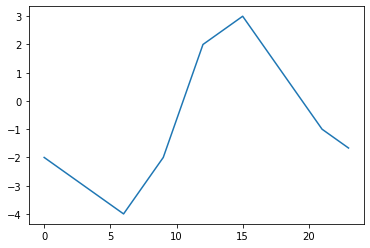

In [11]:
dangjin_fcst_interpolated['Temperature'][:24].plot()

In [12]:
# obs not need interpolation, but for code simplciity
dangjin_obs_interpolated = dangjin_obs
ulsan_obs_interpolated = ulsan_obs

## Convert dtype of 'time' in `energy`
- 'time' of `energy` is 'object'. 
- However, `pd.to_datetime` doesn't accepts '24:00:00' as an hour. Instead accepts '00:00:00'.
- Therefore, custom function is needed.

In [13]:
def to_datetime_for_energy(date_str):
    if date_str[11:13] == '24':
        date_str = date_str[0:11] + '00' + date_str[13:]
        return pd.to_datetime(date_str) + pd.Timedelta(1, unit='days')

    else:
        return pd.to_datetime(date_str)

print(to_datetime_for_energy('2018-03-01 24:00:00'))

2018-03-02 00:00:00


In [14]:
energy['time'] = energy['time'].apply(to_datetime_for_energy)

## Fill missing values - obs
- Fill missing values in `obs` with `fcst`.
 Fill missing values - obs
- Fill missing values in `obs` with `fcst`.
- `fsct`에는 na가 없다는 점을 이용
- @dongi


In [15]:
# count na
print(dangjin_fcst_interpolated.isna().sum())
print(ulsan_fcst_interpolated.isna().sum())
print(dangjin_obs_interpolated.isna().sum())
print(ulsan_obs_interpolated.isna().sum())

Temperature    0
Humidity       0
Cloud          0
Wind_X         0
Wind_Y         0
time           0
dtype: int64
Temperature    0
Humidity       0
Cloud          0
Wind_X         0
Wind_Y         0
time           0
dtype: int64
time              0
Temperature      37
Humidity         35
Cloud          3970
Wind_X           36
Wind_Y           36
dtype: int64
time             0
Temperature      4
Humidity         1
Cloud          825
Wind_X           1
Wind_Y           1
dtype: int64


(array([2450., 1231.,    7.,   24.,   79.,   12.,   39.,    5.,  110.,
          13.]),
 array([17591.        , 17693.05416667, 17795.10833333, 17897.1625    ,
        17999.21666667, 18101.27083333, 18203.325     , 18305.37916667,
        18407.43333333, 18509.4875    , 18611.54166667]),
 <BarContainer object of 10 artists>)

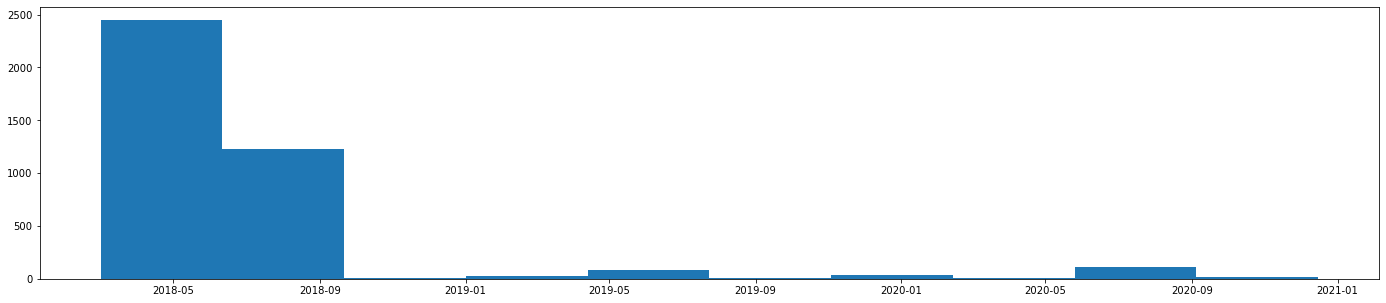

In [16]:
# hist
dj_cloud_na = dangjin_obs_interpolated[dangjin_obs_interpolated['Cloud'].isna()]
plt.figure(figsize=(24,5))
plt.hist(dj_cloud_na['time'])

(array([512., 270.,   0.,   6.,   8.,   0.,   4.,   2.,  18.,   5.]),
 array([17591.08333333, 17690.75833333, 17790.43333333, 17890.10833333,
        17989.78333333, 18089.45833333, 18189.13333333, 18288.80833333,
        18388.48333333, 18488.15833333, 18587.83333333]),
 <BarContainer object of 10 artists>)

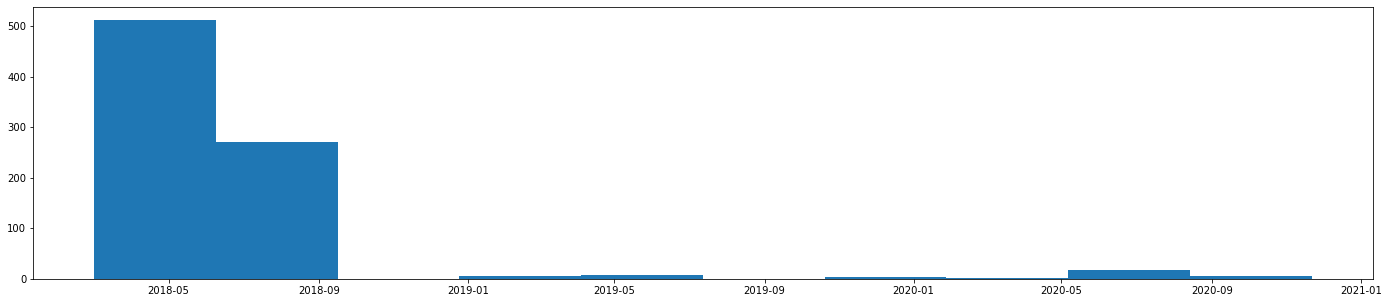

In [17]:
uls_cloud_na = ulsan_obs_interpolated[ulsan_obs_interpolated['Cloud'].isna()]
plt.figure(figsize=(24,5))
plt.hist(uls_cloud_na['time'])

In [18]:
# obs는 2018-03-01 00:00:00 부터, fcst는 2018-03-02 00:00:00 부터이므로 fcst에 기준
dangjin_obs_interpolated = dangjin_obs_interpolated[dangjin_obs_interpolated.time >= '2018-03-02 00:00:00'].reset_index(drop=True)
ulsan_obs_interpolated = ulsan_obs_interpolated[ulsan_obs_interpolated.time >= '2018-03-02 00:00:00'].reset_index(drop=True)

In [19]:
dangjin_obs_interpolated

,time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
0,2018-03-02 00:00:00,-2.7,56.0,NaN,3.700000,-8.817457e-14
1,2018-03-02 01:00:00,-2.8,53.0,NaN,3.800000,-8.817457e-14
2,2018-03-02 02:00:00,-3.2,52.0,NaN,2.500000,-8.817457e-14
3,2018-03-02 03:00:00,-3.5,50.0,NaN,2.443201,6.840403e+00
4,2018-03-02 04:00:00,-4.2,55.0,NaN,0.899903,3.830222e+01
...,...,...,...,...,...,...
25597,2021-01-31 19:00:00,6.7,75.0,8.0,-1.409539,-6.840403e+01
25598,2021-01-31 20:00:00,6.2,77.0,8.0,-0.751754,-6.840403e+01
25599,2021-01-31 21:00:00,5.3,82.0,8.0,-0.449951,-1.761902e+02
25600,2021-01-31 22:00:00,5.8,77.0,8.0,-0.939693,-6.840403e+01


In [20]:
# obs fill based on 'time' from fcst
dangjin_obs_filled = dangjin_obs_interpolated.set_index('time').fillna(dangjin_fcst_interpolated.set_index('time')).reset_index()
ulsan_obs_filled = ulsan_obs_interpolated.set_index('time').fillna(ulsan_fcst_interpolated.set_index('time')).reset_index()

In [21]:
# fcst data (for code)
dangjin_fcst_filled = dangjin_fcst_interpolated
ulsan_fcst_filled = ulsan_fcst_interpolated

In [22]:
print(dangjin_fcst_filled.isna().sum())
print(ulsan_fcst_filled.isna().sum())
print(dangjin_obs_filled.isna().sum())
print(ulsan_obs_filled.isna().sum())

Temperature    0
Humidity       0
Cloud          0
Wind_X         0
Wind_Y         0
time           0
dtype: int64
Temperature    0
Humidity       0
Cloud          0
Wind_X         0
Wind_Y         0
time           0
dtype: int64
time           0
Temperature    0
Humidity       0
Cloud          0
Wind_X         0
Wind_Y         0
dtype: int64
time           0
Temperature    0
Humidity       0
Cloud          0
Wind_X         0
Wind_Y         0
dtype: int64


## Fill missing values - energy

enery:  
- dangjin_floating과 dangjin_warehouse에서 n/a가 나타남.  
- dangjin mean과 dangjin_floating mean, dangjin_warehouse mean과의 비를 통해 채운다.

In [23]:
energy = energy[energy.time >= '2018-03-02 00:00:00'].reset_index(drop=True)
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-02 00:00:00,0.0,0.0,0,0
1,2018-03-02 01:00:00,0.0,0.0,0,0
2,2018-03-02 02:00:00,0.0,0.0,0,0
3,2018-03-02 03:00:00,0.0,0.0,0,0
4,2018-03-02 04:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25604,2021-01-31 20:00:00,0.0,0.0,0,0
25605,2021-01-31 21:00:00,0.0,0.0,0,0
25606,2021-01-31 22:00:00,0.0,0.0,0,0
25607,2021-01-31 23:00:00,0.0,0.0,0,0


---

In [24]:
energy.isna().sum()

time                  0
dangjin_floating     24
dangjin_warehouse    48
dangjin               0
ulsan                 0
dtype: int64

In [25]:
# convert dangjin to dangjin_warehouse or dangjin_floating via 비율 of mean
energy_mean_series = energy.mean(axis=0)
dj_to_djwh = energy_mean_series['dangjin_warehouse'] / energy_mean_series['dangjin'] 
dj_to_djflt = energy_mean_series['dangjin_floating'] / energy_mean_series['dangjin']

dj_to_djwh, dj_to_djflt

(0.6621590413217061, 0.8738813084300028)

In [26]:
# slice where data is na
na_dangjin_warehouse = energy.loc[energy['dangjin_warehouse'].isna()] # df where dangjin_warehouse = na
na_dangjin_warehouse.loc[:,'dangjin_warehouse'] = na_dangjin_warehouse['dangjin'] * dj_to_djwh

na_dangjin_floating = energy.loc[energy['dangjin_floating'].isna()] # df where dangjin_floating = na
na_dangjin_floating.loc[:,'dangjin_floating'] = na_dangjin_floating['dangjin'] * dj_to_djflt

In [27]:
# create filled df
energy_filled = energy.copy()

energy_filled[energy['dangjin_warehouse'].isna()] = na_dangjin_warehouse
energy_filled[energy['dangjin_floating'].isna()] = na_dangjin_floating

energy_filled.isna().sum()

time                 0
dangjin_floating     0
dangjin_warehouse    0
dangjin              0
ulsan                0
dtype: int64

## Drop potential nas (where 24 target values in one day are all zero) - energy

In [28]:
# There are days where all 24 target values are all zero.
# This should be interpreted as an error.
# Therefore, change all the 0 of the above situation to NA

target_list = ['dangjin','dangjin_floating', 'dangjin_warehouse', 'ulsan']
energy_is_zero_dict = {target:[] for target in target_list} # store indices where the whole day is zero
energy_is_zero = list()

for i in range(energy_filled.shape[0] // 24):
    idx = i*24    
    energy_sample = energy_filled.iloc[idx:idx+24]
    energy_sample_sum = energy_sample.sum(axis=0)

    for target in target_list:
        if energy_sample_sum[target] == 0:
            # save index(day)
            energy_is_zero_dict[target].append(i)
            energy_is_zero.append(i)

In [29]:
# drop those rows
energy_filled_dropped = energy_filled.copy()

for i in set(energy_is_zero):
    idx = i*24
    to_drop = [idx + n for n in range(24)]
    energy_filled_dropped.drop(index=to_drop, inplace=True)

## Merge fcst, obs, and energy
- inner merge on 'time'

In [30]:
print(dangjin_fcst_filled.shape)
print(dangjin_obs_filled.shape)
print(ulsan_fcst_filled.shape)
print(ulsan_obs_filled.shape)
print(energy_filled_dropped.shape)

(26353, 6)
(25602, 6)
(26353, 6)
(25608, 6)
(24673, 5)


In [31]:
dangjin_obs_filled.describe()

,Temperature,Humidity,Cloud,Wind_X,Wind_Y
count,25602.000000,25602.000000,25602.000000,2.560200e+04,25602.000000
mean,12.964261,72.945987,5.237653,5.152671e-01,-52.110583
std,10.160823,20.382679,3.582834,1.830077e+00,106.241361
min,-19.300000,10.000000,0.000000,-1.170000e+01,-272.510860
25%,4.700000,57.150000,2.000000,-4.041334e-16,-116.286849
50%,13.600000,76.000000,6.000000,4.000000e-01,0.000000
75%,21.500000,92.000000,8.000000,1.436485e+00,6.840403
max,36.800000,99.000000,10.000000,9.584865e+00,103.366188


In [32]:
dangjin_merged_ = pd.merge(dangjin_fcst_filled, dangjin_obs_filled, on='time', suffixes=('_fcst','_obs'))
dangjin_merged = pd.merge(dangjin_merged_, energy_filled_dropped.loc[:,['time','dangjin_floating','dangjin_warehouse','dangjin']], on='time')

ulsan_merged_ = pd.merge(ulsan_fcst_filled, ulsan_obs_filled, on='time', suffixes=('_fcst','_obs'))
ulsan_merged = pd.merge(ulsan_merged_, energy_filled_dropped.loc[:,['time','ulsan']], on='time')

display(dangjin_merged)
display(ulsan_merged)

,Temperature_fcst,Humidity_fcst,Cloud_fcst,Wind_X_fcst,Wind_Y_fcst,time,Temperature_obs,Humidity_obs,Cloud_obs,Wind_X_obs,Wind_Y_obs,dangjin_floating,dangjin_warehouse,dangjin
0,-2.000000,50.000000,2.763537,5.298564,-136.663512,2018-03-02 00:00:00,-2.7,56.0,2.763537,3.700000,-8.817457e-14,0.0,0.0,0
1,-2.333333,51.666667,2.763537,5.088343,-131.604586,2018-03-02 01:00:00,-2.8,53.0,2.763537,3.800000,-8.817457e-14,0.0,0.0,0
2,-2.666667,53.333333,2.763537,4.878123,-126.545661,2018-03-02 02:00:00,-3.2,52.0,2.763537,2.500000,-8.817457e-14,0.0,0.0,0
3,-3.000000,55.000000,2.763537,4.667902,-121.486735,2018-03-02 03:00:00,-3.5,50.0,2.763537,2.443201,6.840403e+00,0.0,0.0,0
4,-3.333333,56.666667,2.763537,4.468414,-95.331116,2018-03-02 04:00:00,-4.2,55.0,2.763537,0.899903,3.830222e+01,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24661,6.000000,76.666667,7.961345,-3.521363,-3.549990,2021-01-31 19:00:00,6.7,75.0,8.000000,-1.409539,-6.840403e+01,0.0,0.0,0
24662,6.000000,78.333333,7.961345,-3.668069,15.689587,2021-01-31 20:00:00,6.2,77.0,8.000000,-0.751754,-6.840403e+01,0.0,0.0,0
24663,6.000000,80.000000,7.961345,-3.814776,34.929164,2021-01-31 21:00:00,5.3,82.0,8.000000,-0.449951,-1.761902e+02,0.0,0.0,0
24664,6.333333,80.000000,7.961345,-4.538312,27.378489,2021-01-31 22:00:00,5.8,77.0,8.000000,-0.939693,-6.840403e+01,0.0,0.0,0


,Temperature_fcst,Humidity_fcst,Cloud_fcst,Wind_X_fcst,Wind_Y_fcst,time,Temperature_obs,Humidity_obs,Cloud_obs,Wind_X_obs,Wind_Y_obs,ulsan
0,0.000000,40.000000,3.591006,1.010290,-202.011846,2018-03-02 00:00:00,1.3,37.0,7.000000,3.194955,-1.162868e+02,0
1,-0.333333,41.666667,3.591006,0.964412,-221.844994,2018-03-02 01:00:00,0.5,42.0,3.591006,2.000000,-8.817457e-14,0
2,-0.666667,43.333333,3.591006,0.918535,-241.678143,2018-03-02 02:00:00,-0.4,46.0,3.591006,2.300000,-8.817457e-14,0
3,-1.000000,45.000000,3.591006,0.872657,-261.511292,2018-03-02 03:00:00,-0.9,48.0,9.000000,1.879385,6.840403e+00,0
4,-1.000000,45.000000,2.967691,0.917287,-258.350002,2018-03-02 04:00:00,-1.5,51.0,8.000000,2.161293,-1.162868e+02,0
...,...,...,...,...,...,...,...,...,...,...,...,...
24667,8.666667,60.000000,8.638197,-2.629993,-75.790243,2021-01-31 19:00:00,8.8,50.0,5.000000,-2.349232,-6.840403e+01,0
24668,8.333333,65.000000,8.638197,-2.787240,-90.395122,2021-01-31 20:00:00,8.7,49.0,1.000000,-3.664801,-6.840403e+01,0
24669,8.000000,70.000000,8.638197,-2.944486,-105.000000,2021-01-31 21:00:00,8.4,51.0,7.000000,-1.542690,-1.761902e+02,0
24670,9.000000,68.333333,8.638197,-3.476275,-86.823238,2021-01-31 22:00:00,9.4,51.0,8.000000,-2.121199,-1.761902e+02,0


## Add seasonality (day and year)

In [33]:
# function for day_of_year
def day_of_year(datetime): #pd.datetime
    return pd.Period(datetime, freq='D').dayofyear

print(dangjin_fcst_filled.iloc[0]['time'])
print(day_of_year(dangjin_fcst_filled.iloc[0]['time']))

2018-03-02 00:00:00
61


In [34]:
# function
def add_seasonality(df):
    new_df = df.copy()
    
    new_df['Day_cos'] = new_df['time'].apply(lambda x: np.cos(x.hour * (2 * np.pi) / 24))
    new_df['Day_sin'] = new_df['time'].apply(lambda x: np.sin(x.hour * (2 * np.pi) / 24))

    new_df['Year_cos'] = new_df['time'].apply(lambda x: np.cos(day_of_year(x) * (2 * np.pi) / 365))
    new_df['Year_sin'] = new_df['time'].apply(lambda x: np.sin(day_of_year(x) * (2 * np.pi) / 365))

    return new_df

In [35]:
# apply
dangjin_merged_with_season = add_seasonality(dangjin_merged)
ulsan_merged_with_season = add_seasonality(ulsan_merged)

dangjin_fcst_with_season = add_seasonality(dangjin_fcst_filled)
ulsan_fcst_with_season = add_seasonality(ulsan_fcst_filled)
dangjin_obs_with_season = add_seasonality(dangjin_obs_filled)
ulsan_obs_with_season = add_seasonality(ulsan_obs_filled)

In [36]:
# check
print(dangjin_fcst_with_season.loc[4,['time','Day_cos','Day_sin','Year_cos','Year_sin']])
print(dangjin_fcst_with_season.loc[4 + 24,['time','Day_cos','Day_sin']])
print(dangjin_fcst_with_season.loc[4 + 24*365,['time','Year_cos','Year_sin']])

time        2018-03-02 04:00:00
Day_cos                     0.5
Day_sin                0.866025
Year_cos               0.497513
Year_sin               0.867456
Name: 4, dtype: object
time       2018-03-03 04:00:00
Day_cos                    0.5
Day_sin               0.866025
Name: 28, dtype: object
time        2019-03-02 04:00:00
Year_cos               0.497513
Year_sin               0.867456
Name: 8764, dtype: object


## Pickle dfs

In [37]:
with open('pickles/dangjin_merged.pkl','wb') as f:
    pickle.dump(dangjin_merged_with_season,f)
with open('pickles/ulsan_merged.pkl','wb') as f:
    pickle.dump(ulsan_merged_with_season,f)

with open('pickles/dangjin_fcst.pkl','wb') as f:
    pickle.dump(dangjin_fcst_with_season, f)
with open('pickles/dangjin_obs.pkl','wb') as f:
    pickle.dump(dangjin_obs_with_season, f)
with open('pickles/ulsan_fcst.pkl','wb') as f:
    pickle.dump(ulsan_fcst_with_season, f)
with open('pickles/ulsan_obs.pkl','wb') as f:
    pickle.dump(ulsan_obs_with_season, f)
    